<a href="https://colab.research.google.com/github/anajikadam17/Google-Colab/blob/main/NLP/Sentiment_Analysis_Using_BERT_PART_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Dependencies

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.1MB/s 
     |████████████████████████████████| 3.3MB 42.7MB/s 
     |████████████████████████████████| 901kB 45.2MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Read Data
path = "/content/drive/MyDrive/Colab/NLP/Data/"
df = pd.read_csv(path+"reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOF3BBW6LGgIs0svMJpnKnst1lsDpoh0ZjPpcxm...,Claude Smoot,https://play-lh.googleusercontent.com/a-/AOh14...,As like every other App. They want your money....,1,31,5.14.2.5,2021-06-24 12:35:20,"90% of the app is completely free, including a...",2021-06-27 15:04:33,most_relevant,com.anydo
1,gp:AOqpTOGgpF0Qjaitvi19zsNvTBLHGmLQXt5NDVQQ0UM...,Juliana Claps,https://play-lh.googleusercontent.com/a/AATXAJ...,"This keeps crashing, freezing, not responding....",1,8,5.14.2.6,2021-07-03 14:50:08,We're sorry to hear you're experiencing issues...,2021-07-04 09:36:49,most_relevant,com.anydo
2,gp:AOqpTOF04AnjWDqCqPw3UxsSSEWJqM1c3JblBFwsMc3...,Naman Dubey,https://play-lh.googleusercontent.com/a-/AOh14...,I am not getting reminders in my phone. Tried ...,1,0,5.14.2.5,2021-07-02 04:29:04,As long as you’ve turned your reminders ON and...,2021-07-04 09:20:49,most_relevant,com.anydo
3,gp:AOqpTOFPuTz3z9qTwUpM9QJOX77baUesnI-CtW7pecU...,Brad Betts,https://play-lh.googleusercontent.com/a-/AOh14...,This app implied that it had better integratio...,1,77,5.14.1.2,2021-06-01 00:50:22,Our Help Center https://bit.ly/3c8a3yX provide...,2021-06-01 08:24:43,most_relevant,com.anydo
4,gp:AOqpTOHCgsbGpZHpflISF-U3PRKnunyfB1BkhN73nep...,Wanie,https://play-lh.googleusercontent.com/a-/AOh14...,"I've used this before and dumped it, and I gav...",1,63,5.14.0.7,2021-04-29 08:26:50,"Hey, you can simply swipe it back from right t...",2021-04-29 10:05:58,most_relevant,com.anydo


In [ ]:
df.shape

(16420, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16420 entries, 0 to 16419
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16420 non-null  object
 1   userName              16420 non-null  object
 2   userImage             16420 non-null  object
 3   content               16419 non-null  object
 4   score                 16420 non-null  int64 
 5   thumbsUpCount         16420 non-null  int64 
 6   reviewCreatedVersion  13992 non-null  object
 7   at                    16420 non-null  object
 8   replyContent          8491 non-null   object
 9   repliedAt             8491 non-null   object
 10  sortOrder             16420 non-null  object
 11  appId                 16420 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


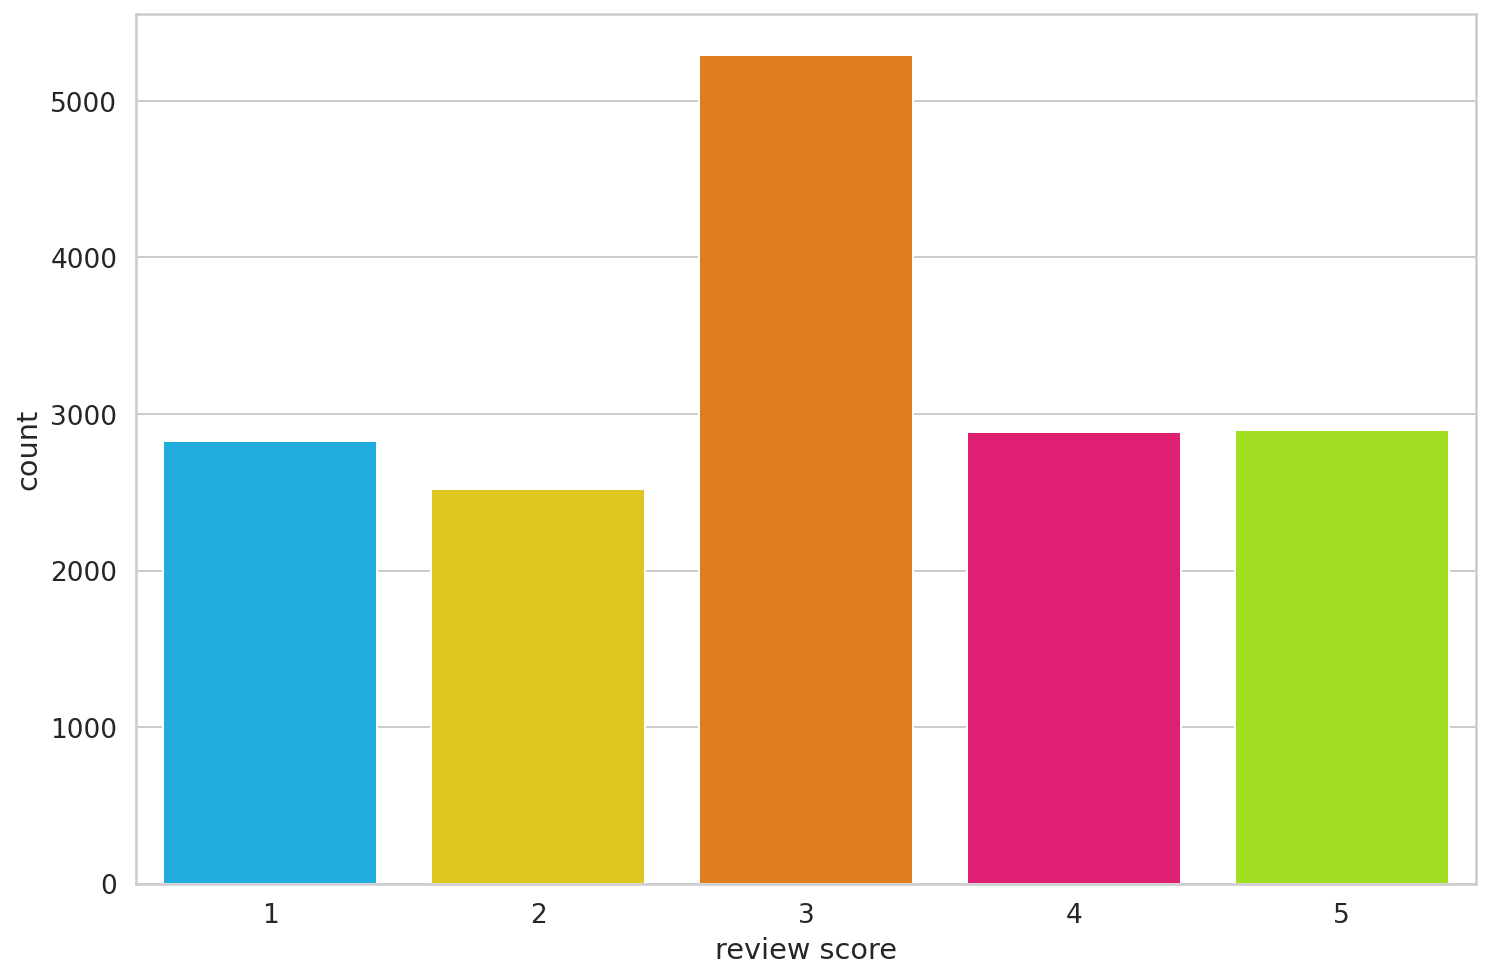

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

In [ ]:
def group_sentiment(rating):
  #rating = int(rating)
  if rating <= 2:
    return 0         # Negetive sentiment
  elif rating == 3:
    return 1         # Neutral Sentiment
  else: 
    return 2         # positive Sentiment

df['sentiment'] = df.score.apply(group_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


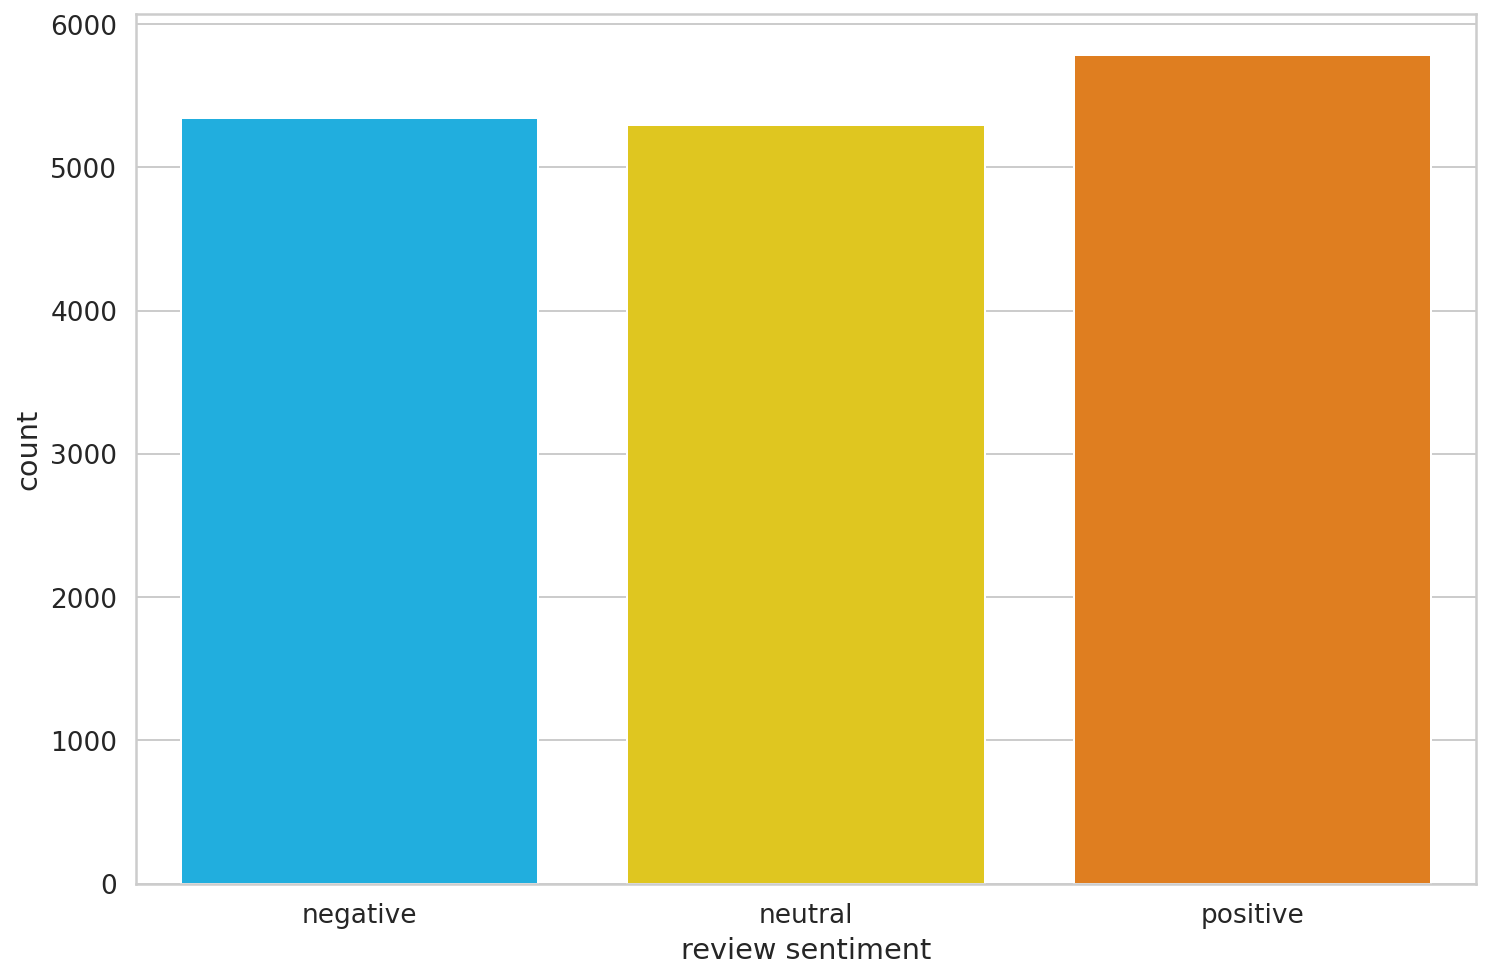

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

## Data Preprocessing
Machine Learning models don't work with raw text. We need to convert text to numbers (of some sort). BERT requires even more attention. Here are the requirements:

Add special tokens to separate sentences and do classification
Pass sequences of constant length (introduce padding)
Create array of 0s (pad token) and 1s (real token) called attention mask
The Transformers library provides a wide variety of Transformer models (including BERT). It also includes prebuilt tokenizers that solves most of the load required for pre-processing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# Let's load a pre-trained BertTokenizer:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

The requirements of special tokens which indicate seperation between sentences is taken care by the tokenizer provided by the huggingface. BERT was trained for question and answering task but we are using it to train with a sequence of sentences as input. We require sequences of equal length which is done by padding tokens of zero meaning without loss of generality to the end of sentences.

We also need to pass attention mask which is basically passing a value of 1 to all the tokens which have meaning and 0 to padding tokens.

We'll use this simple text to understand the tokenization process:

In [ ]:
sample_txt = 'Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.'
#sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Sentence: {sample_txt}')
print(f'\n  Tokens: {tokens}')
print(f'\n  Token IDs: {token_ids}')   # Each token has a an unique ID for the model to unserstand what we are referring to.

  Sentence: Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.

  Tokens: ['Best', 'place', 'that', 'I', 'have', 'visited', '?', 'Iceland', 'was', 'the', 'most', 'beautiful', 'and', 'I', 'consider', 'myself', 'lucky', 'to', 'have', 'visited', 'Iceland', 'at', 'such', 'an', 'early', 'age', '.']

  Token IDs: [1798, 1282, 1115, 146, 1138, 3891, 136, 10271, 1108, 1103, 1211, 2712, 1105, 146, 4615, 1991, 6918, 1106, 1138, 3891, 10271, 1120, 1216, 1126, 1346, 1425, 119]


In [ ]:
len(tokens)

27

## Special Tokens
[SEP] - marker for ending of a sentence

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of the above work can be done using the encode_plus() method

In [ ]:
encoding_test = tokenizer.encode_plus(
  sample_txt,
  max_length=32,           # sequence length
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors(use tf for tensorflow and keras)
)

In [ ]:
encoding_test.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(' length of the first sequence is :  ', len(encoding_test['input_ids'][0]))
print('\n The input id\'s are : \n', encoding_test['input_ids'][0])
print('\n The attention mask generated is : ', encoding_test['attention_mask'][0])

 length of the first sequence is :   29

 The input id's are : 
 tensor([  101,  1798,  1282,  1115,   146,  1138,  3891,   136, 10271,  1108,
         1103,  1211,  2712,  1105,   146,  4615,  1991,  6918,  1106,  1138,
         3891, 10271,  1120,  1216,  1126,  1346,  1425,   119,   102])

 The attention mask generated is :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1])


We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding_test['input_ids'].flatten())

['[CLS]',
 'Best',
 'place',
 'that',
 'I',
 'have',
 'visited',
 '?',
 'Iceland',
 'was',
 'the',
 'most',
 'beautiful',
 'and',
 'I',
 'consider',
 'myself',
 'lucky',
 'to',
 'have',
 'visited',
 'Iceland',
 'at',
 'such',
 'an',
 'early',
 'age',
 '.',
 '[SEP]']

## Choosing Sequence Length
Check if there are any nan in the content column

In [ ]:
df.loc[df.content.isnull()]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
6831,gp:AOqpTOG9sPlhaD3qWtDnutnfK6V1V9Vs3Sl7XTlWhnp...,m-94 Mujahid,https://play-lh.googleusercontent.com/a-/AOh14...,NaN,4,0,NaN,2021-03-05 14:11:49,NaN,NaN,newest,com.oristats.habitbull,2


In [ ]:
df = df[df['content'].notna()]
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOF3BBW6LGgIs0svMJpnKnst1lsDpoh0ZjPpcxm...,Claude Smoot,https://play-lh.googleusercontent.com/a-/AOh14...,As like every other App. They want your money....,1,31,5.14.2.5,2021-06-24 12:35:20,"90% of the app is completely free, including a...",2021-06-27 15:04:33,most_relevant,com.anydo,0
1,gp:AOqpTOGgpF0Qjaitvi19zsNvTBLHGmLQXt5NDVQQ0UM...,Juliana Claps,https://play-lh.googleusercontent.com/a/AATXAJ...,"This keeps crashing, freezing, not responding....",1,8,5.14.2.6,2021-07-03 14:50:08,We're sorry to hear you're experiencing issues...,2021-07-04 09:36:49,most_relevant,com.anydo,0
2,gp:AOqpTOF04AnjWDqCqPw3UxsSSEWJqM1c3JblBFwsMc3...,Naman Dubey,https://play-lh.googleusercontent.com/a-/AOh14...,I am not getting reminders in my phone. Tried ...,1,0,5.14.2.5,2021-07-02 04:29:04,As long as you’ve turned your reminders ON and...,2021-07-04 09:20:49,most_relevant,com.anydo,0
3,gp:AOqpTOFPuTz3z9qTwUpM9QJOX77baUesnI-CtW7pecU...,Brad Betts,https://play-lh.googleusercontent.com/a-/AOh14...,This app implied that it had better integratio...,1,77,5.14.1.2,2021-06-01 00:50:22,Our Help Center https://bit.ly/3c8a3yX provide...,2021-06-01 08:24:43,most_relevant,com.anydo,0
4,gp:AOqpTOHCgsbGpZHpflISF-U3PRKnunyfB1BkhN73nep...,Wanie,https://play-lh.googleusercontent.com/a-/AOh14...,"I've used this before and dumped it, and I gav...",1,63,5.14.0.7,2021-04-29 08:26:50,"Hey, you can simply swipe it back from right t...",2021-04-29 10:05:58,most_relevant,com.anydo,0


In [ ]:
df.loc[df.content.isnull()]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment


BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []
for text in df.content:
    tokens_df = tokenizer.encode(text, max_length=512)   # Max possible length for the BERT model.
    token_lens.append(len(tokens_df))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


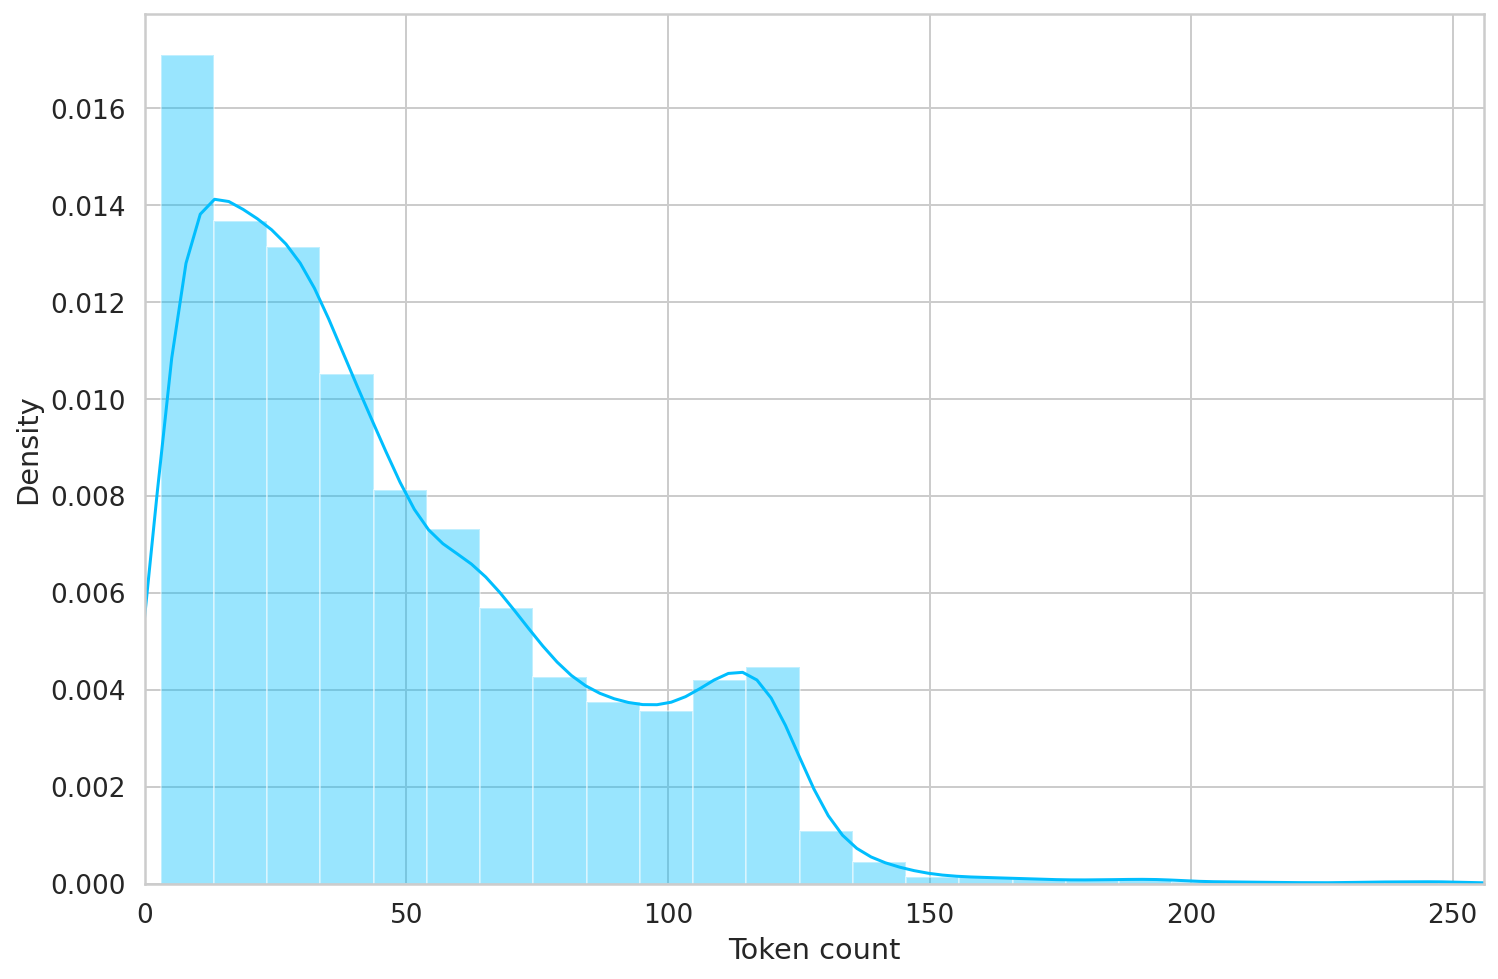

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 150 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's use the same class:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews         # Reviews is content column.
    self.targets = targets         # Target is the sentiment column.
    self.tokenizer = tokenizer     # Tokenizer is the BERT_Tokanizer.
    self.max_len = max_len         # max_length of each sequence.
  
  def __len__(self):
    return len(self.reviews)       # Len of each review.
  
  def __getitem__(self, item):
    review = str(self.reviews[item])   # returns the string of reviews at the index = 'items'
    target = self.targets[item]        # returns the string of targets at the index = 'items'

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,                                   
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)            # dictionary containing all the features is returned.
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

## Splitting into train and validation sets

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((13135, 13), (1642, 13), (1642, 13))

Create data loaders for to feed as input to our model. The below function does that.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.values,
    targets=df.sentiment.values,
    tokenizer=tokenizer,
    max_len=max_len
  )                                  # Dataset would be created which can be used to create and return dataloader.

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4
  )

In [ ]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 160])
torch.Size([8, 160])
torch.Size([8])


## Sentiment Classification with BERT and Hugging Face
There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task we might use "BertForSequenceClassification", "BertForQuestionAnswering" or something else.

We'll use the basic BertModel and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_test = bert_model(
  input_ids=encoding_test['input_ids'], 
  attention_mask=encoding_test['attention_mask']
)
model_test.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

The "last_hidden_state" is a sequence of hidden states of the last layer of the model. Obtaining the "pooled_output" is done by applying the BertPooler which basically applies the tanh function to pool all the outputs.

In [ ]:
last_hidden_state=model_test['last_hidden_state']
pooled_output=model_test['pooler_output']

In [ ]:
last_hidden_state.shape

torch.Size([1, 29, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence) and 768 is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768

We can think of the pooled_output as a summary of the content, according to BERT. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all this knowledge to create a sentiment classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)                                 ## For regularization with dropout probability 0.3.
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) ## append an Output fully connected layer representing the number of classes
  
  def forward(self, input_ids, attention_mask):
    returned = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = returned["pooler_output"]
    output = self.drop(pooled_output)
    return self.out(output)

The classifier delegates most of the work to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. We're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We'll move the example batch of our training data created above using dataloader to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 160])
torch.Size([8, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the output obtained from the output layer:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2307, 0.2563, 0.5130],
        [0.2268, 0.2166, 0.5566],
        [0.2593, 0.2134, 0.5274],
        [0.3632, 0.2573, 0.3795],
        [0.2202, 0.1928, 0.5871],
        [0.1983, 0.1226, 0.6791],
        [0.2307, 0.1316, 0.6377],
        [0.2359, 0.2437, 0.5204]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training the model
To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS    # Number of batches * Epochs (Required for the scheduler.)
 
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,     # Recommended in the BERT paper.
  num_training_steps=total_steps  
)

loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors have some recommendations for fine-tuning:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
Except for the number of epochs recommendation We'll stick with the rest. Increasing the batch size reduces the training time significantly, but gives lower accuracy.

Helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()    # To make sure that the droupout and normalization is enabled during the training.

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    max_prob, preds = torch.max(outputs, dim=1)    # Returns 2 tensors, one with max_probability and another with the respective predicted label.
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()     # Back_Propogation
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Recommended by the BERT paper to clip the gradients to avoid exploding gradients.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)     # Return the mean loss and the ratio of correct predictions.

Training the model is similar to training a deep neural network, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm

Helper function to evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()        # To make sure that the droupout and normalization is disabled during the training.

  losses = []
  correct_predictions = 0

  with torch.no_grad():        # Back propogation is not required. Torch would perform faster. 
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      max_prob, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using these two helper functions, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)          # Similar to Keras library saves history
best_accuracy = 0                    

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.7665683062027927 accuracy 0.648344118766654
Val   loss 0.6244821920267587 accuracy 0.730816077953715

Epoch 2/10
----------
Train loss 0.4935261051348625 accuracy 0.8153026265702321
Val   loss 0.6595795144082852 accuracy 0.774056029232643

Epoch 3/10
----------
Train loss 0.3297269134556797 accuracy 0.9027027027027027
Val   loss 0.8739642791774405 accuracy 0.7990255785627284

Epoch 4/10
----------
Train loss 0.2445219257848708 accuracy 0.9374952417205937
Val   loss 0.9259938900805422 accuracy 0.8142509135200974

Epoch 5/10
----------
Train loss 0.16126549528965523 accuracy 0.9601065854586981
Val   loss 1.083692165393268 accuracy 0.8233861144945188

Epoch 6/10
----------
Train loss 0.1287238917255344 accuracy 0.9692424819185382
Val   loss 1.2891559869176579 accuracy 0.8038976857490865

Epoch 7/10
----------
Train loss 0.10121767658080182 accuracy 0.9751046821469356
Val   loss 1.260383285801086 accuracy 0.8191230207064555

Epoch 8/10
----------
Train loss 0.07055199197488708

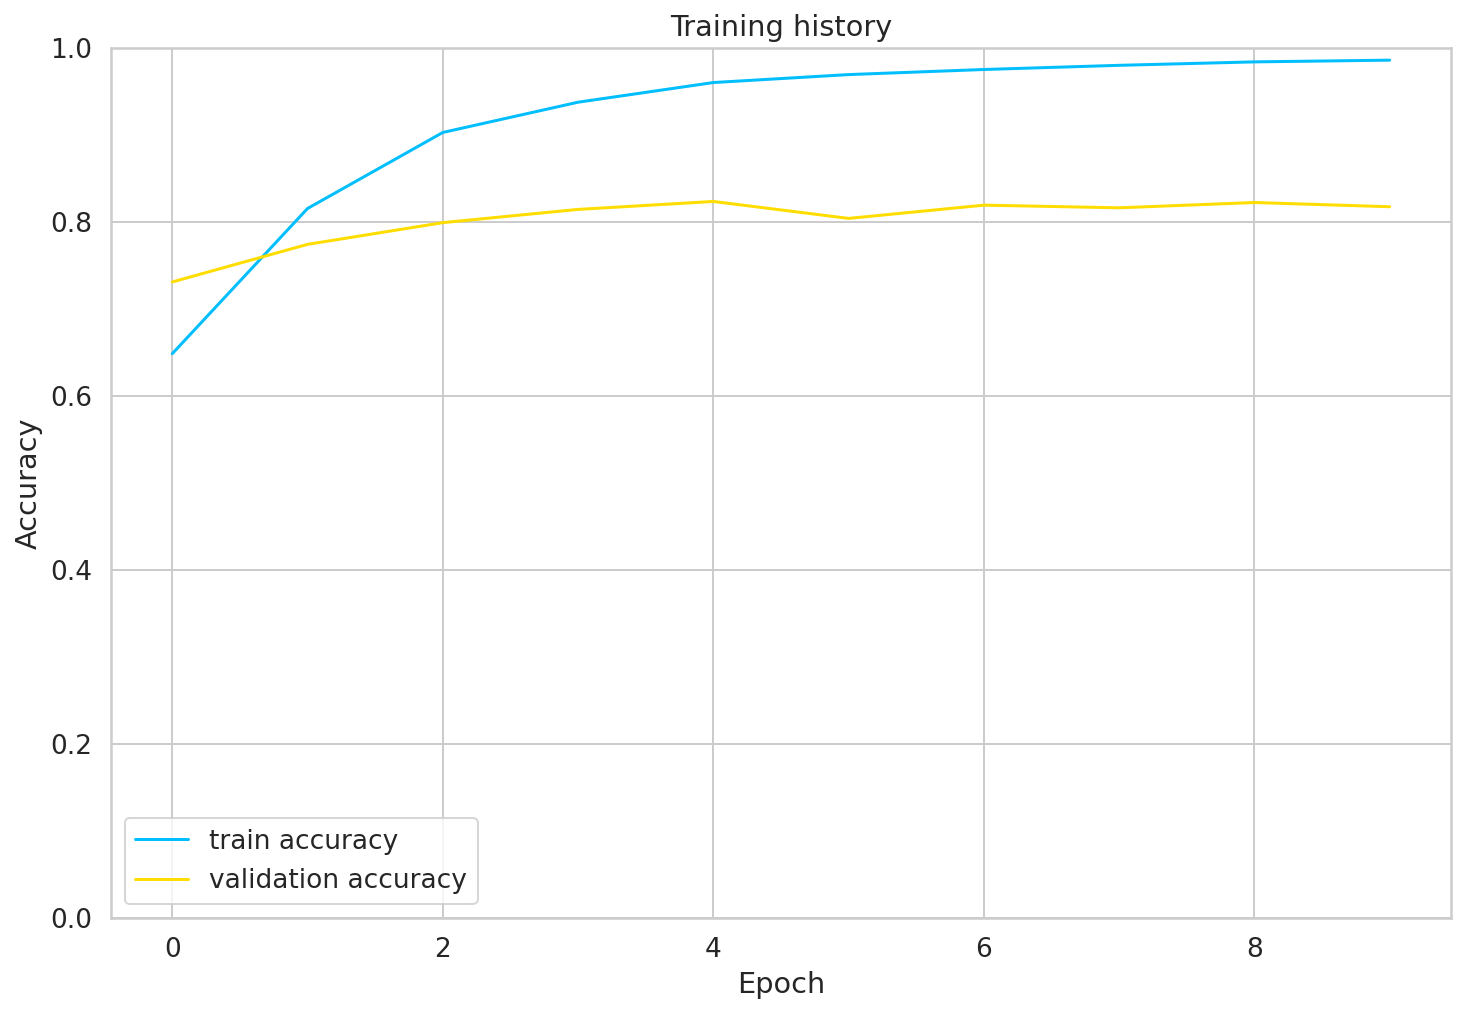

In [ ]:
# Note that we're storing the state of the best model, indicated by the highest validation accuracy.
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Evaluation
So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.820341047503045

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.83      0.85       552
     neutral       0.74      0.79      0.76       524
    positive       0.86      0.84      0.85       566

    accuracy                           0.82      1642
   macro avg       0.82      0.82      0.82      1642
weighted avg       0.82      0.82      0.82      1642



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

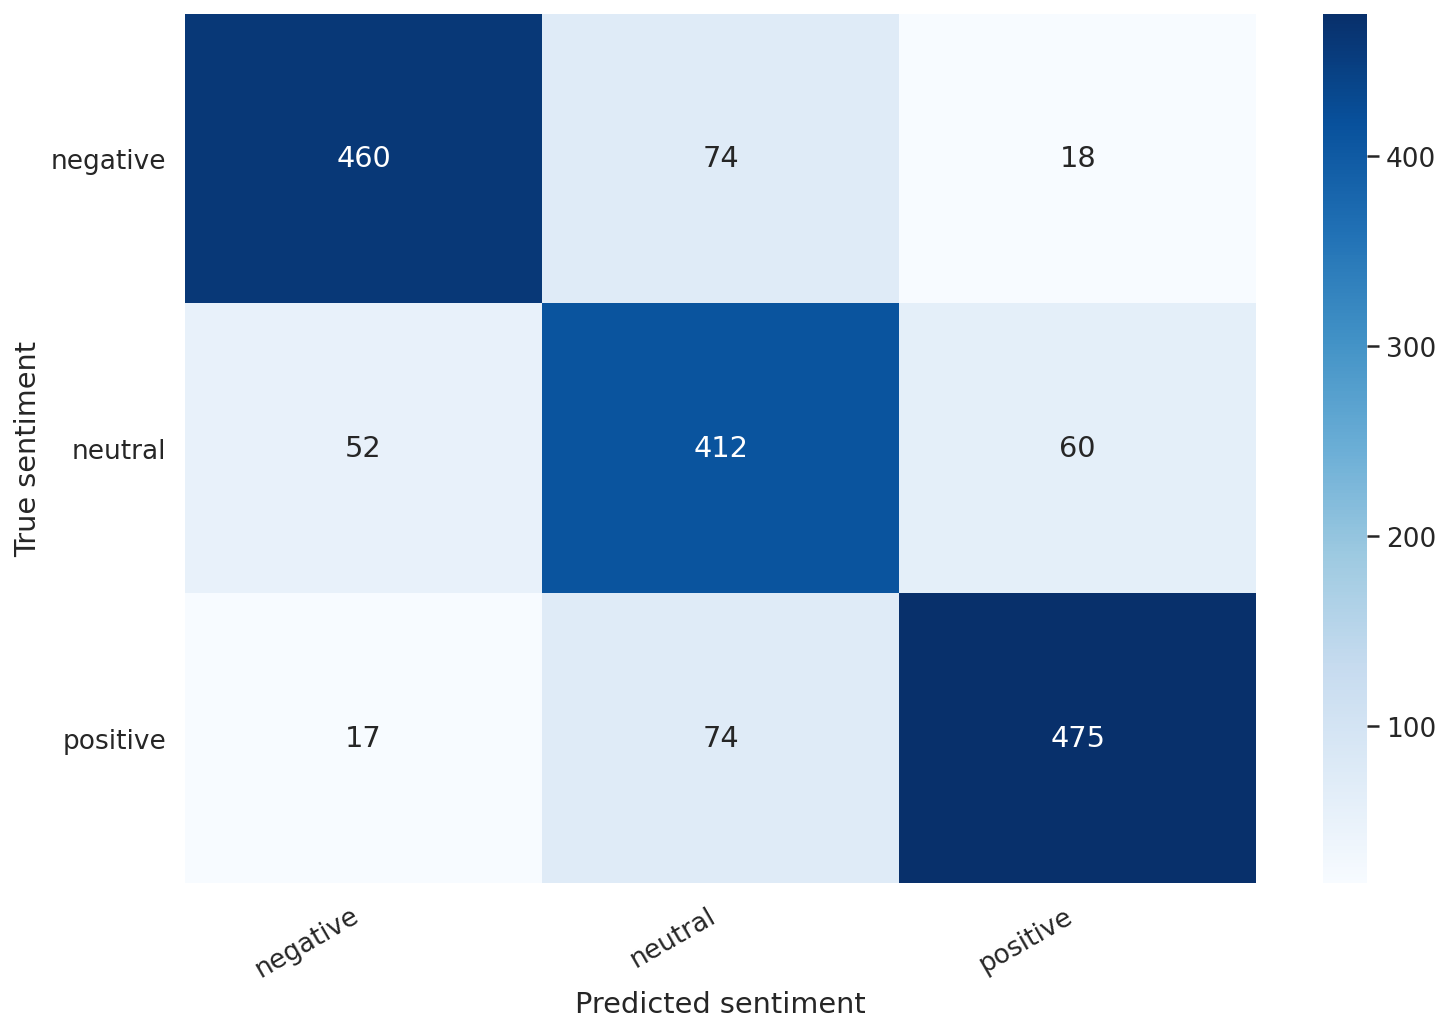

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Good app, needs more purchase options. I want to show my support for
the project- but . . . I dont want all the features that come with
premium, i literally just want to upload custom sounds. I dont want
the scheduling or themes or any of that other stuff. Could there be
more options to purchase by themselves? I want to buy features
permanently since i see myself using this app for a long time, I'd be
willing to spend a couple or so bucks, not the full 45$

True sentiment: positive


Now we can look at the confidence of each sentiment of our model:

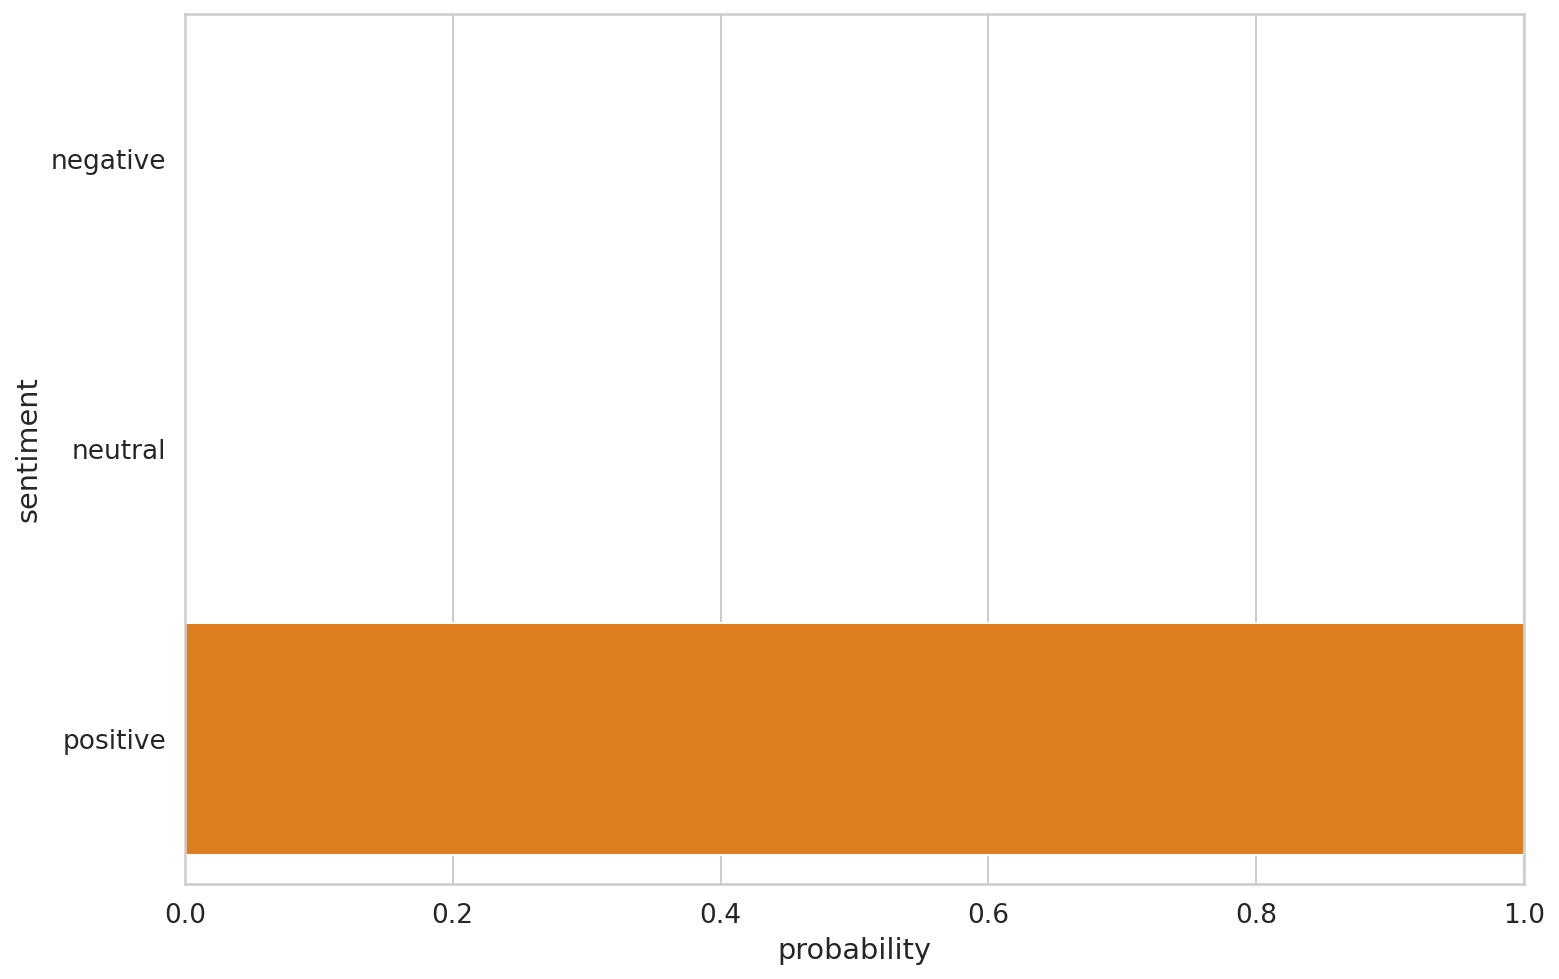

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predicting on Raw Text
Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
